In [1]:
import psycopg2
import numpy as np

print('connecting to postgres...')
connection = psycopg2.connect(user="max",
                              password="password",
                              host="127.0.0.1",
                              port="5432",
                              database="final")
print()
print(connection)
cursor = connection.cursor()

connecting to postgres...

<connection object at 0x7f18347b5768; dsn: 'user=max password=xxx dbname=final host=127.0.0.1 port=5432', closed: 0>


In [2]:
connection.rollback()

In [3]:
q = """
SELECT * FROM popular_spotify_features;
"""

cursor.execute(q)
spotify = cursor.fetchall()

In [4]:
len(spotify)

167947

In [5]:
import pandas as pd

columns = ['lastfm_artist_track', 'spotify_artist_track', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'uri', 'analysis_url', 'duration_ms',
       'time_signature']

df = pd.DataFrame(spotify, columns=columns)

In [6]:
feats = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode', 
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo', 
    'duration_ms',
    'time_signature' 
]

df[feats] = df[feats].astype(float)

In [7]:
df_feats = df[feats]

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from itertools import product


std_scl = StandardScaler()
X_scl = std_scl.fit_transform(df_feats)
X_sample = X_scl[np.random.choice(len(X_scl), size=25000, replace=False), :]

epsilons = np.linspace(0.01, 1.01, num=10, endpoint=False)
min_samples = np.arange(5, 15, 2)

grid = product(epsilons, min_samples)

results = {}
for eps, min_sample in grid:
    dbscan = DBSCAN(eps=eps, min_samples=min_sample)
    dbscan.fit(X_scl)
    size = len(set(dbscan.labels_)) - 1
    results[(eps, min_sample)] = size

In [29]:
results

{(0.01, 5): 26,
 (0.01, 7): 3,
 (0.01, 9): 2,
 (0.01, 11): 0,
 (0.01, 13): 0,
 (0.11, 5): 27,
 (0.11, 7): 3,
 (0.11, 9): 2,
 (0.11, 11): 0,
 (0.11, 13): 0,
 (0.21000000000000002, 5): 28,
 (0.21000000000000002, 7): 3,
 (0.21000000000000002, 9): 2,
 (0.21000000000000002, 11): 0,
 (0.21000000000000002, 13): 0,
 (0.31000000000000005, 5): 30,
 (0.31000000000000005, 7): 4,
 (0.31000000000000005, 9): 2,
 (0.31000000000000005, 11): 0,
 (0.31000000000000005, 13): 0,
 (0.41000000000000003, 5): 45,
 (0.41000000000000003, 7): 5,
 (0.41000000000000003, 9): 2,
 (0.41000000000000003, 11): 0,
 (0.41000000000000003, 13): 0,
 (0.51, 5): 249,
 (0.51, 7): 61,
 (0.51, 9): 25,
 (0.51, 11): 7,
 (0.51, 13): 3,
 (0.6100000000000001, 5): 415,
 (0.6100000000000001, 7): 162,
 (0.6100000000000001, 9): 80,
 (0.6100000000000001, 11): 42,
 (0.6100000000000001, 13): 34,
 (0.7100000000000001, 5): 486,
 (0.7100000000000001, 7): 162,
 (0.7100000000000001, 9): 94,
 (0.7100000000000001, 11): 49,
 (0.7100000000000001, 13): 

In [32]:
# let's take a look at (.5, 10)

dbscan = DBSCAN(eps=.5, min_samples=10)
dbscan.fit(X_scl)


DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None)

In [34]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scl)

In [39]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

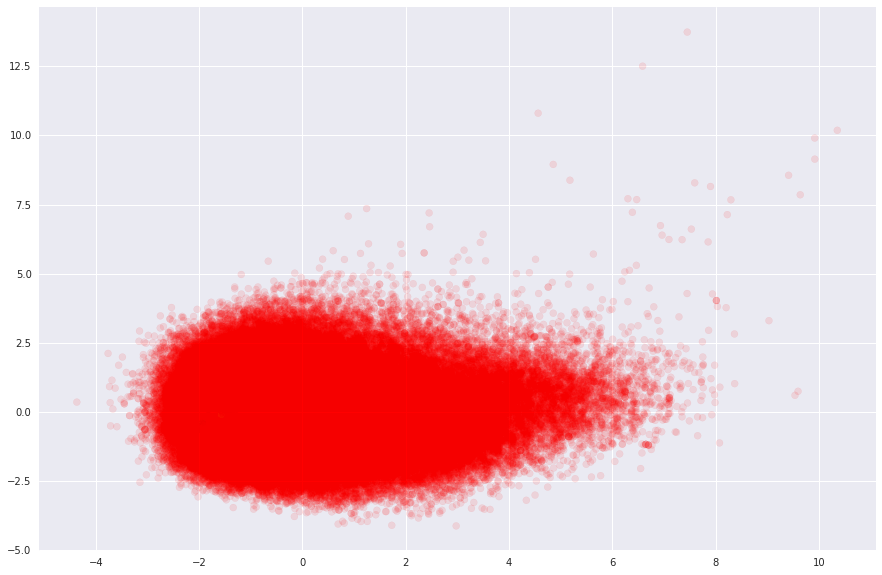

In [44]:
plt.figure(figsize=(15,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan.labels_, cmap='prism', alpha=.1)

In [46]:
counts = {}
label_set = set(dbscan.labels_)
for label in label_set:
    counts[label] = sum(dbscan.labels_ == label)

In [47]:
counts

{0: 69,
 1: 14,
 2: 10,
 3: 13,
 4: 10,
 5: 11,
 6: 16,
 7: 10,
 8: 10,
 9: 10,
 -1: 167774}

### Let's try clustering on the user data

In [53]:
del spotify

In [3]:
q = """
SELECT arist_track FROM lastfm
    GROUP BY arist_track
    HAVING COUNT(lastfm_user) > 8 
;
"""

cursor.execute(q)
lastfm_tracks = cursor.fetchall()

In [4]:
lastfm_tracks = set(track[0] for track in lastfm_tracks)

In [5]:
q = """
SELECT * FROM lastfm
;
"""

cursor.execute(q)

lastfm = []
batch = cursor.fetchmany(10000)
while batch:
    for row in batch:
        if row[1] in lastfm_tracks:
            lastfm.append(row)
    batch = cursor.fetchmany(10000)

In [6]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix


columns = [
    'username',
    'artist_track',
    'count'
    ]

df = pd.DataFrame(lastfm, columns=columns)

X = df.values
X[:,2] = X[:, 2].astype(int)

# generate unique ids for track
unique_artist_tracks = df['artist_track'].unique()

# remembering the index of each artist_track
ix_artist_track = dict(zip(unique_artist_tracks, range(len(unique_artist_tracks))))
artist_track_ix = {v:k for k, v in ix_artist_track.items()}

df['track_ix'] = df['artist_track'].apply(lambda x: ix_artist_track[x])

# geneate unique ids for each username
unique_usernames = df['username'].unique()
ix_username = dict(zip(unique_usernames, range(len(unique_usernames))))
df['username_ix'] = df['username'].apply(lambda x: ix_username[x])

# (row, column, values)

rcv = ['username_ix', 'track_ix', 'count']
X = df[rcv].astype(int).values
X[:,2] = X[:,2].astype(bool).astype(int) # change values to be 1

# csr_matrix((data, (row, col))
row = X[:, 1]  # track_ixs
col = X[:, 0]  # username_ixs 
data = X[:, 2] # always 1

sparse_mat = csr_matrix((data, (row, col)))

tsvd = TruncatedSVD(n_components=10)

tsvd.fit(sparse_mat) 

mat_tsvd = tsvd.transform(sparse_mat)

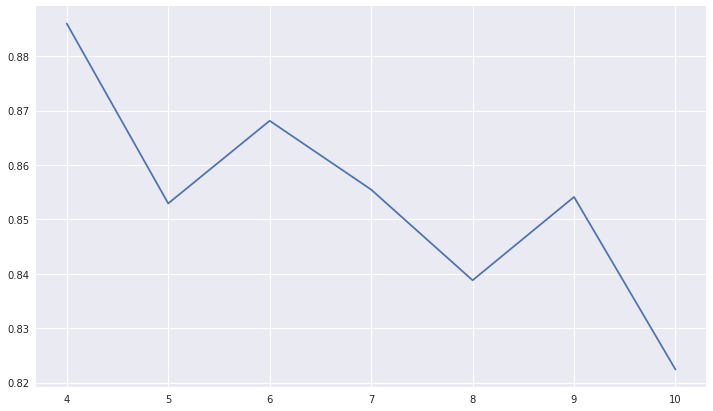

In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_sample = X_scl[np.random.choice(len(mat_tsvd), size=4000, replace=False), :]

ks = np.arange(4,11,1)

results = [silhouette_score(X_sample, KMeans(n_clusters=k).fit(X_sample).labels_) for k in ks]
plt.figure(figsize=(12,7))
plt.plot(ks, results)

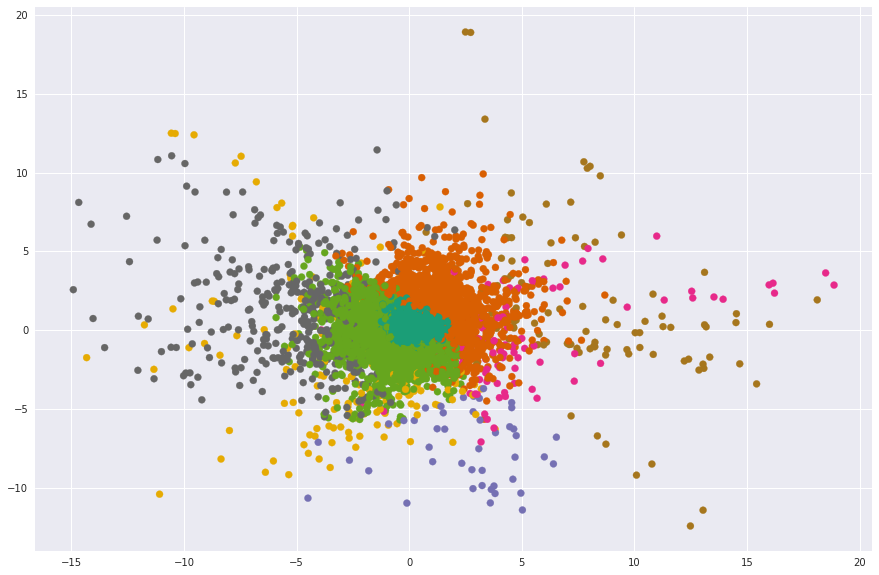

In [66]:
plt.figure(figsize=(15,10))
plt.scatter(mat_tsvd[:, 1], mat_tsvd[:, 3], c=labels, cmap='Dark2')

### DBSCAN with Cosine Similarity

<BarContainer object of 8 artists>

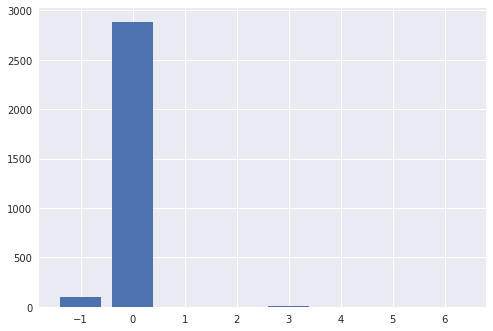

In [136]:
dbscan = DBSCAN(eps=.16, min_samples=3 ,metric='cosine')
X_sample = X_scl[np.random.choice(len(X_scl), size=3000, replace=False), :]
labels = dbscan.fit_predict(X_sample)

counts = {}
for label in set(labels):
    counts[label] = sum(labels == label)
    
x = list(counts.keys())
y = list(counts.values())
plt.bar(x,y)

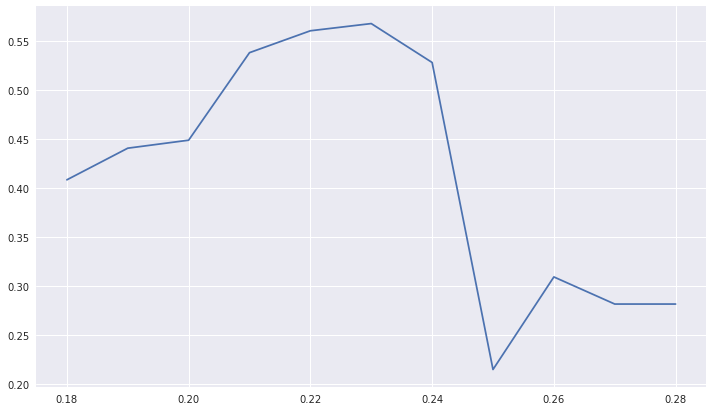

In [143]:
epsilons = np.arange(.18, .28, .01)
results = [silhouette_score(X_sample, DBSCAN(eps=eps, min_samples=5, metric='cosine').fit_predict(X_sample)) 
           for eps in epsilons]
plt.figure(figsize=(12,7))
plt.plot(epsilons, results)

In [149]:
# winner was eps=.23
X_sample = mat_tsvd[np.random.choice(len(mat_tsvd), size=5000, replace=False)]
dbscan = DBSCAN(eps=.23, min_samples=5, metric='cosine')
lables = dbscan.fit_predict(X_sample)

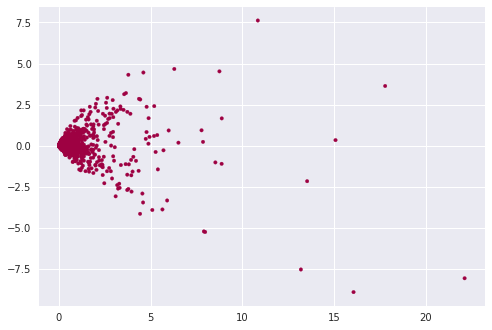

In [173]:
plt.scatter(X_sample[:, 0], X_sample[:,3], c=lables, cmap='Spectral', marker=".")

In [174]:
counts = {}
for label in set(labels):
    counts[label] = sum(labels == label)
    
counts

{0: 2882, 1: 3, 2: 3, 3: 5, 4: 3, 5: 3, 6: 3, -1: 98}

### Normalize vectors then KMeans

In [7]:
X_norm = np.array([x/np.linalg.norm(x) for x in mat_tsvd])

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X_sample = X_norm[np.random.choice(len(X_norm), size=10000, replace=False), :]

ks = np.arange(2,20,1)

results = [silhouette_score(X_sample, KMeans(n_clusters=k).fit(X_sample).labels_) for k in ks]
plt.figure(figsize=(12,7))
plt.plot(ks, results)

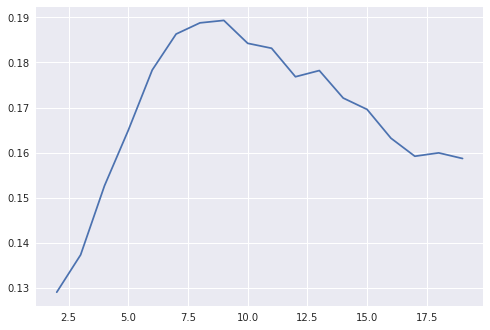

In [9]:
plt.style.use('seaborn')

plt.plot(ks, results)

In [10]:
del mat_tsvd
silhouette_score(X_sample, KMeans(n_clusters=8).fit(X_sample).labels_)

0.18871507819278632

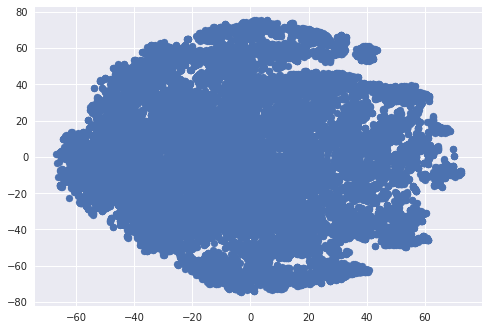

In [69]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

In [16]:
del X_norm